# NBA MVP Historical Analysis

## Appending the csv files to create the Dataset 

In [1]:
import pandas as pd
import pathlib
import random as rd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import BallTree
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn import datasets

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [2]:
nba_dataset = pd.DataFrame()

for season in np.arange(1981,2021,1):
    df = pd.read_csv(f'./data/{season}_std.csv', low_memory=False)    
    nba_dataset = nba_dataset.append(df)

display(nba_dataset)

Player Pos  Age   G    MP   FG   FGA    FG%   3P  3PA  ...  \
0    Kareem Abdul-Jabbar   C   33  80  2976  836  1457  0.574    0    1  ...   
1          Tom Abernethy  SF   26  39   298   25    59  0.424    0    1  ...   
2            Alvan Adams   C   26  75  2054  458   870  0.526    0    0  ...   
3         Darrell Allums  PF   22  22   276   23    67  0.343    0    1  ...   
4         Tiny Archibald  PG   32  80  2820  382   766  0.499    0    9  ...   
..                   ...  ..  ...  ..   ...  ...   ...    ...  ...  ...  ...   
524           Trae Young  PG   21  60  2120  546  1249  0.437  205  568  ...   
525          Cody Zeller   C   27  58  1341  251   479  0.524   18   75  ...   
526         Tyler Zeller   C   30   2     4    1     4  0.250    0    0  ...   
527           Ante Žižić   C   23  22   221   41    72  0.569    0    0  ...   
528          Ivica Zubac   C   22  72  1326  236   385  0.613    0    2  ...   

       WS  WS/48  OBPM  DBPM   BPM  VORP  First  Share     Status  Season  
0    14.3  0.230   4.7   1.4   6.1   6.1      8  0.414  Candidate    1981  
1     0.4  0.062  -2.2  -0.4  -2.6   0.0      0  0.000        OOR    1981  
2     7.7  0.180   2.5   2.6   5.1   3.7      0  0.000        OOR    1981  
3    -0.3 -0.054  -5.5  -0.1  -5.6  -0.3      0  0.000        OOR    1981  
4     6.9  0.118   0.9  -1.0  -0.1   1.4      0  0.046  Candidate    1981  
..    ...    ...   ...   ...   ...   ...    ...    ...        ...     ...  
524   5.9  0.133   6.2  -2.3   3.9   3.1      0  0.000        OOR    2020  
525   3.6  0.129   0.2  -0.8  -0.6   0.5      0  0.000        OOR    2020  
526   0.0 -0.075  -0.3 -22.1 -22.4   0.0      0  0.000        OOR    2020  
527   0.5  0.106  -1.7  -1.5  -3.2  -0.1      0  0.000        OOR    2020  
528   6.6  0.241   1.9   0.8   2.8   1.6      0  0.000        OOR    2020  

[16852 rows x 51 columns]

Way too many features, we need to remove some of them.

## Feature Removing

In [3]:
cols = ['G','MP','FG','FG%','3P','2P','FT','TRB','DRB%','ORB%','OWS','DWS','WS/48','OBPM','DBPM','First']
print(f"Removing {len(cols)} features.")
nba_dataset = nba_dataset.drop(columns=cols)

Removing 16 features.


## Feature Analysis

<AxesSubplot:>

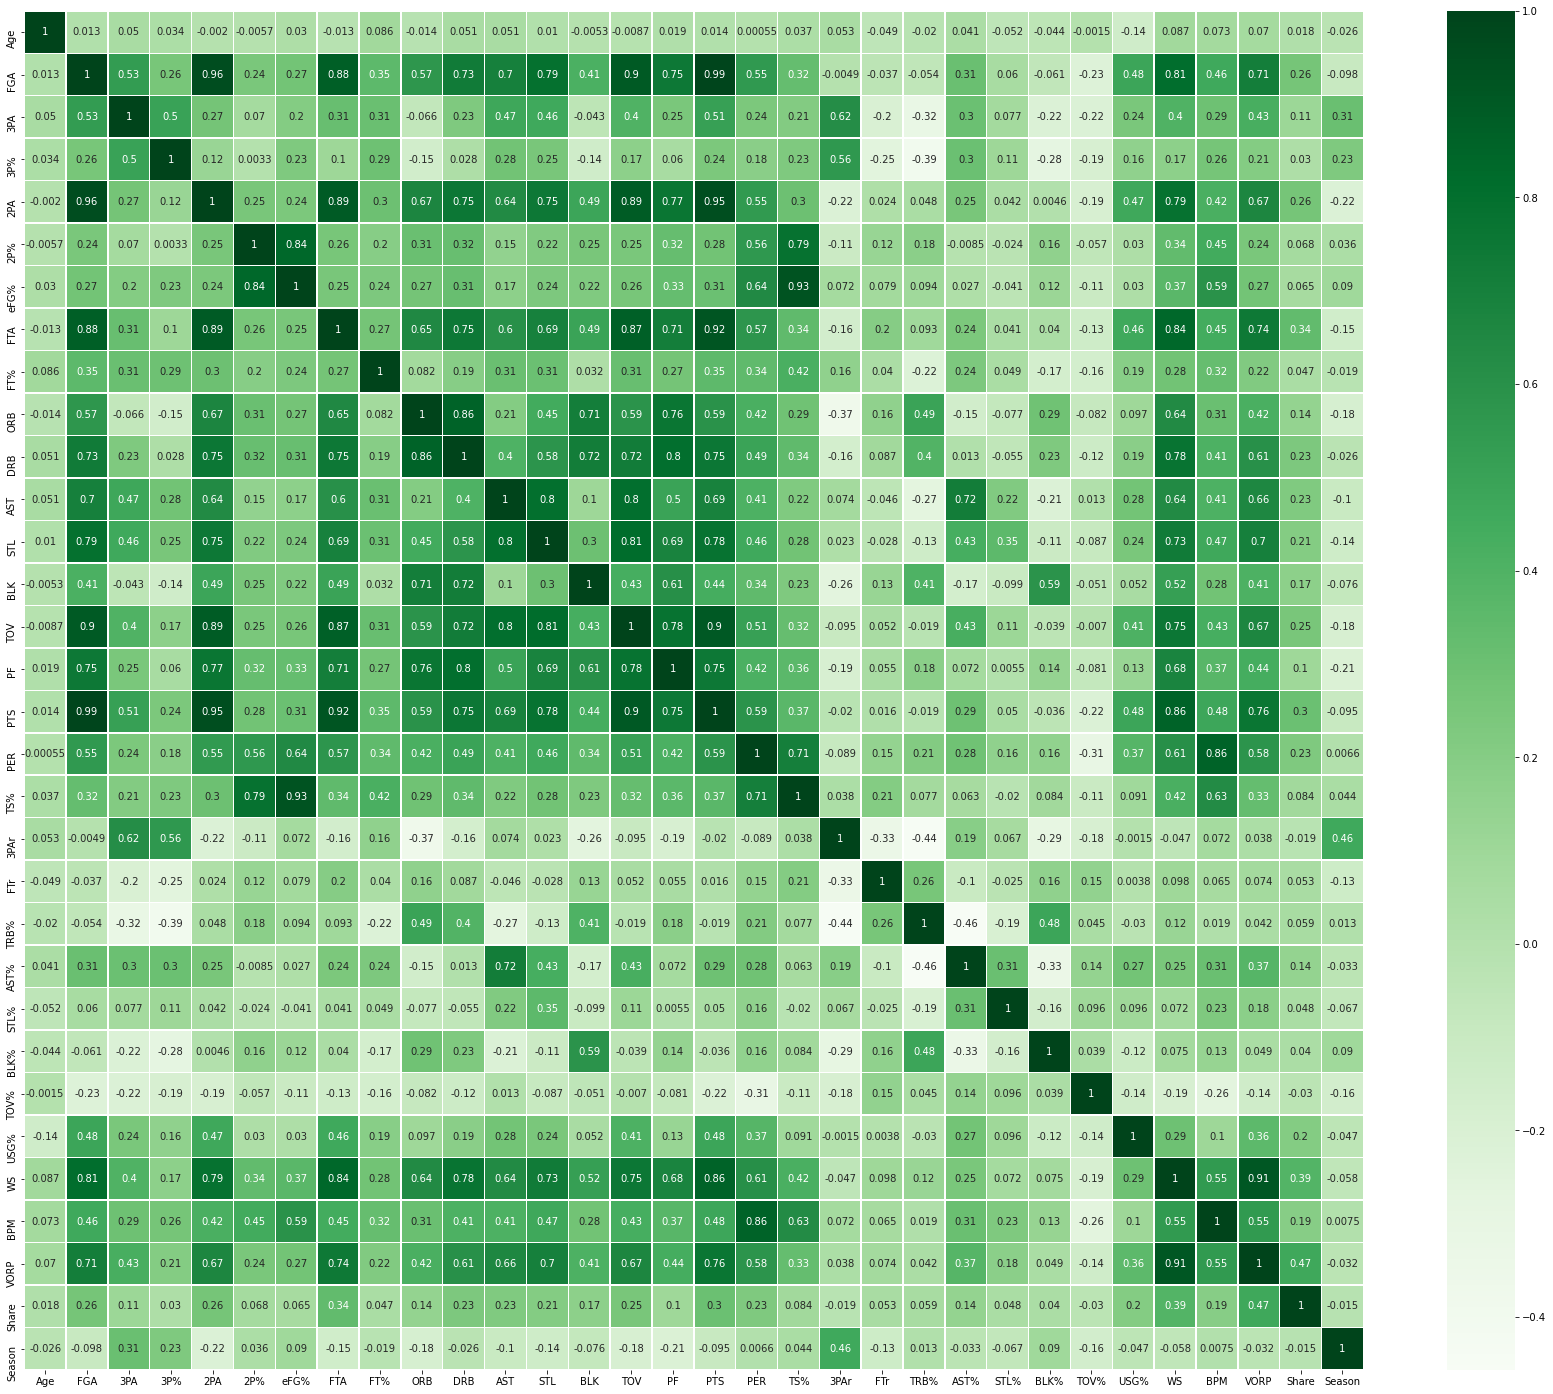

In [4]:
plt.figure(figsize=(30, 25))
sns.heatmap(nba_dataset.corr(), annot=True, cmap='Greens', linewidths=0.5)

I'm gonna keep some features just for further analysis. Once they are not usefull anymore I'll take them out.

## Outlier Analysis

### Functions Definition

In [5]:
def limit_calc(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

In [6]:
def boxplot(column):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=column, ax=ax1)
    ax2.set_xlim(limit_calc(column))
    sns.boxplot(x=column, ax=ax2)
    
def histogram(column,color=None):
    plt.figure(figsize=(15, 5))
    sns.histplot(column,color=color)

def bar_chart(column):  
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=column.value_counts().index, y=column.value_counts())
    ax.set_xlim(limit_calc(column))

### 3-Point Field Goal Percentage

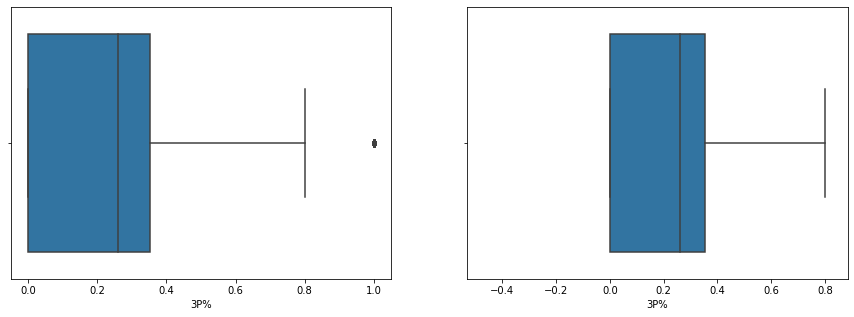

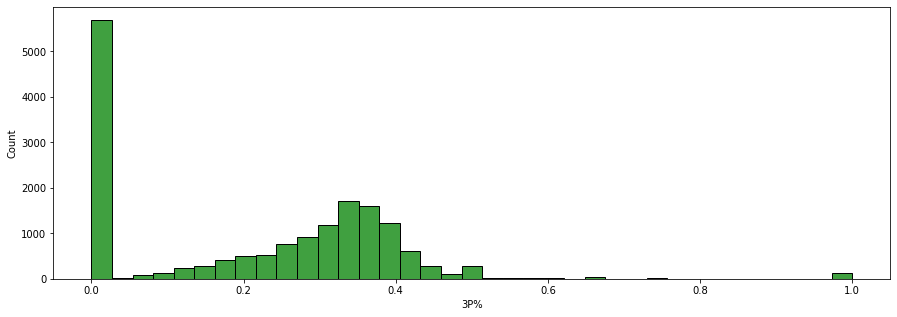

In [7]:
boxplot(nba_dataset['3P%'])
histogram(nba_dataset['3P%'],"Green")

Probably a fews guys had 1 3-pt attempt and managed to score. Those sharpshooters with 100% accuracy gonna be taken out.

Besides that, I gave 3 conditions to keep a player in the Dataset.
<ol>
    <li>Players within the margin: 0% ~ 60% </li>
    <li>Players with more than 60% accuracy can be counted if they tried at least 50 shoots in the season</li>
    <li>Kept the MVP and Candidates regardless their accuracy  </li>  
</ol>

In [8]:
min_val = 0.0
max_val = 0.6

df_size = nba_dataset.shape[0]
nba_dataset = nba_dataset.loc[((nba_dataset['3P%'] >= min_val) & (nba_dataset['3P%'] <= max_val)) 
                              | (nba_dataset['3P%'] > max_val) & (nba_dataset['3PA'] >= 50)
                              | (nba_dataset['Status'] != 'OOR'), :]
removed_rows = df_size - nba_dataset.shape[0]
print('{} rows removed'.format(removed_rows))

193 rows removed


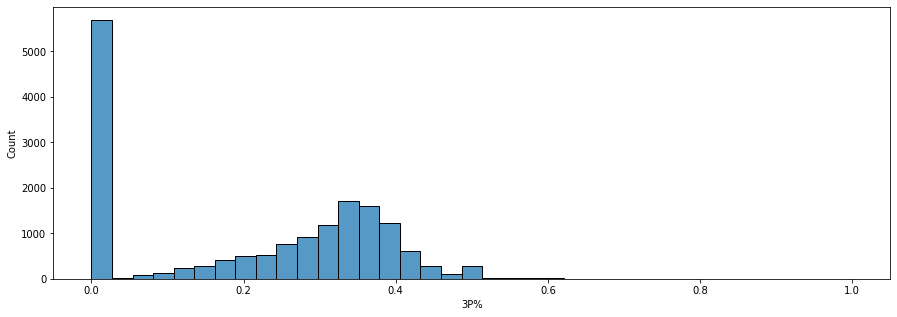

In [9]:
histogram(nba_dataset['3P%'])

### 2-Point Field Goal Percentage

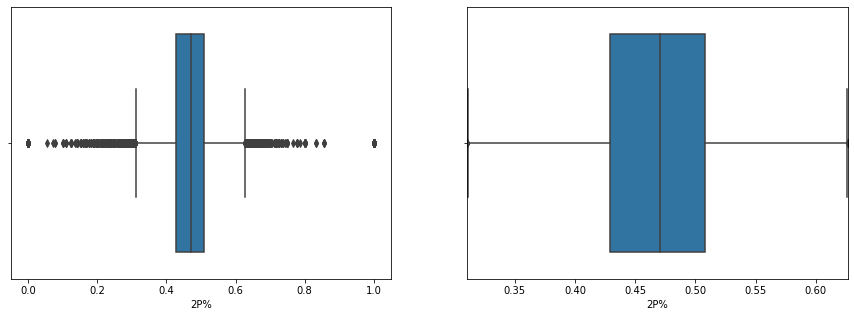

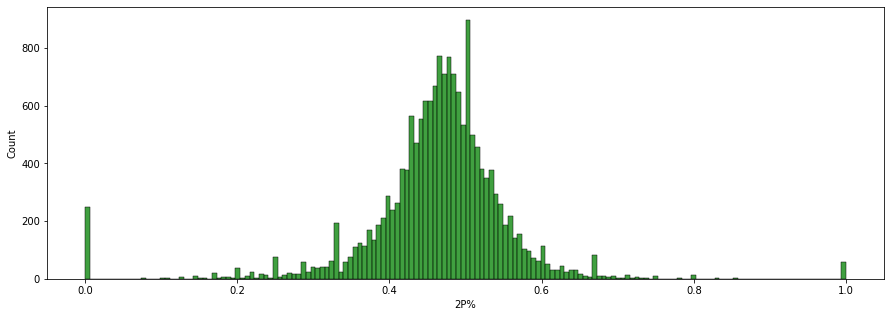

In [10]:
boxplot(nba_dataset['2P%'])
histogram(nba_dataset['2P%'],"Green")

Here again, some bench warmers are generating a few outliers.

The same 3 conditions will be repeated.<br> 
Here we gonna use a quantile (25% - 75%) calculation for the margins and we will consider 250 attempts to validate a outlier accuracy.

In [11]:
min_val, max_val = limit_calc(nba_dataset['2P%'])

df_size = nba_dataset.shape[0]
nba_dataset = nba_dataset.loc[((nba_dataset['2P%'] >= min_val) & (nba_dataset['2P%'] <= max_val)) 
                              | (nba_dataset['2P%'] > max_val) & (nba_dataset['2PA'] >= 250)
                              | (nba_dataset['Status'] != 'OOR'), :]
removed_rows = df_size - nba_dataset.shape[0]
print('{} rows removed'.format(removed_rows))

1039 rows removed


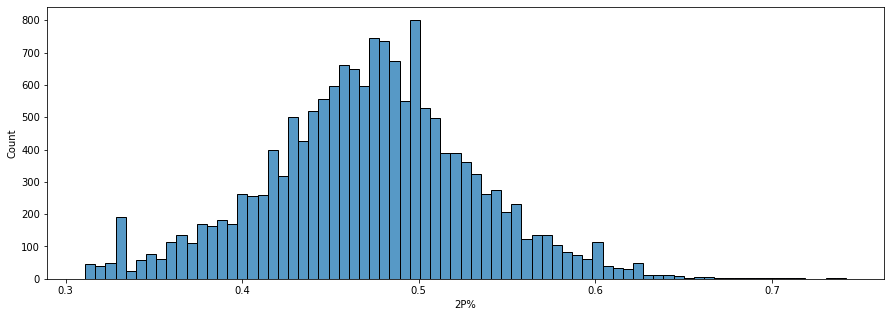

In [12]:
histogram(nba_dataset['2P%'])

### TS% : True Shooting Percentage

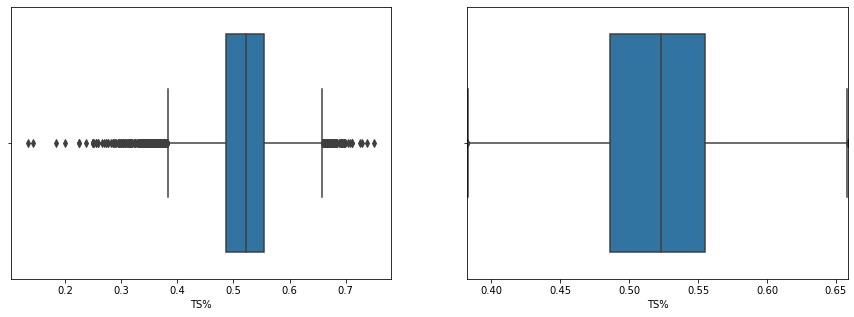

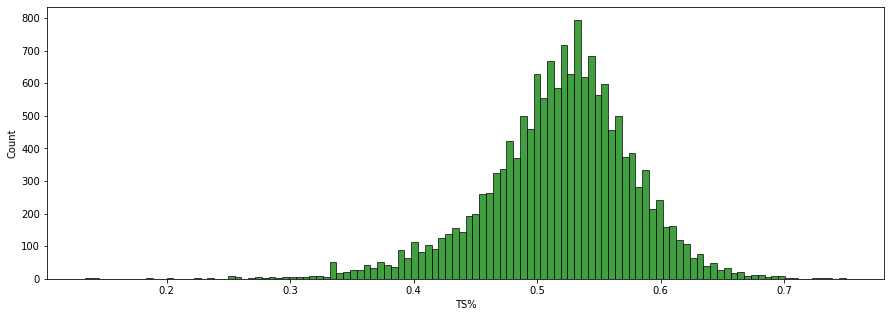

In [13]:
boxplot(nba_dataset['TS%'])
histogram(nba_dataset['TS%'],"Green")

We can see that there's a few guys under 40% and over 65% that may be outliers, let's check.

In [14]:
print(f"NBA FGA mean: {nba_dataset['FGA'].mean():.0F}")

NBA FGA mean: 476


In [15]:
min_val = 0.4
max_val = 0.65

outliers = nba_dataset.loc[((nba_dataset['TS%'] <= min_val) | (nba_dataset['TS%'] >= max_val))
                           & (nba_dataset['FGA'] <= 300), ['Player','Pos','FGA','eFG%','TS%','Season']]
display(outliers.sort_values(by=['TS%','FGA'], ascending=[False,False]))

Player Pos  FGA   eFG%    TS%  Season
32       Manute Bol   C   10  0.750  0.750    1995
311     Steve Novak  SF   67  0.716  0.737    2011
268     Jeff Taylor  SG   10  0.600  0.729    1987
368    Nerlens Noel   C  269  0.686  0.711    2020
257  Keldon Johnson  SF   89  0.669  0.711    2020
..              ...  ..  ...    ...    ...     ...
273  Terrence Jones  PF    4  0.250  0.225    2019
353     Miles Simon  SG    5  0.200  0.200    1999
312    Sedric Toney  PG    5  0.200  0.184    1989
143  Henry Ellenson   C    7  0.143  0.143    2020
312       Mark Pope  SF    7  0.143  0.134    1999

[695 rows x 6 columns]

Even though those guys have less then 300 attempts in a season, I will not consider them deviants as many of them are famous players.

### FT% : Free Throw Percentage

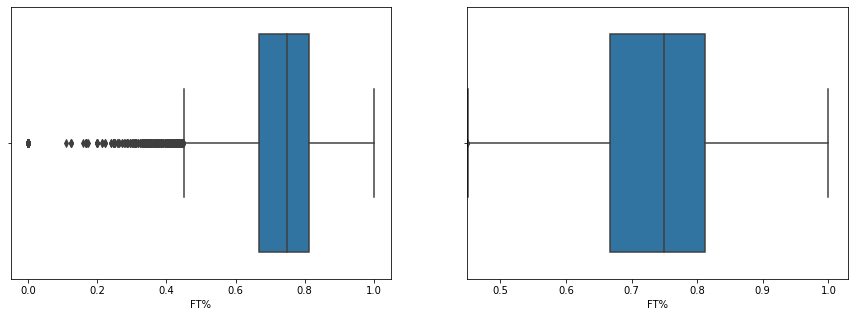

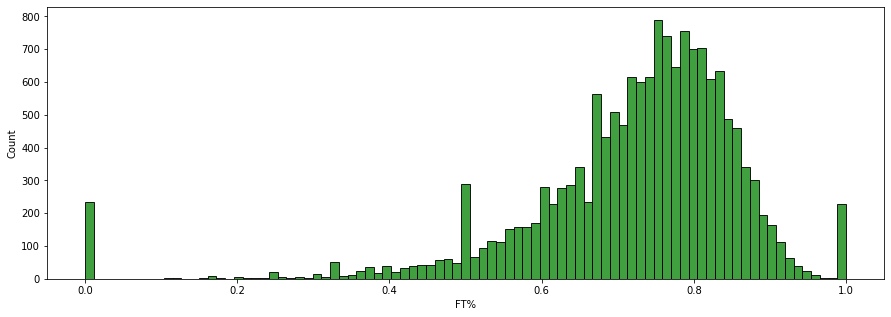

In [16]:
boxplot(nba_dataset['FT%'])
histogram(nba_dataset['FT%'],"Green")

It seems that too many guys had 0% or 100% accuracy. Again, weird numbers.

Gonna treat that, by taking the mean of Free Throw Attempts in count.

In [17]:
print(f"FTA mean: {nba_dataset['FTA'].mean():.0F}")

FTA mean: 146


So let's consider one fourth of the FTA mean (50 attempts) as the margin and see what happens.

In [18]:
df_size = nba_dataset.shape[0]
nba_dataset = nba_dataset.loc[(nba_dataset['FTA'] >= 50)
                              | (nba_dataset['Status'] != 'OOR'), :]
removed_rows = df_size - nba_dataset.shape[0]
print('{} rows removed'.format(removed_rows))

4671 rows removed


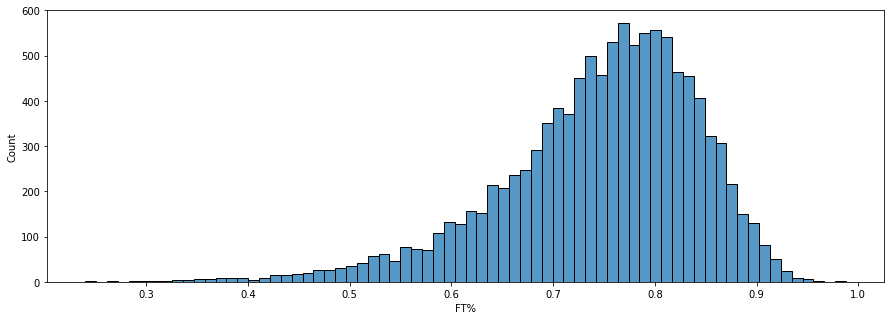

In [19]:
histogram(nba_dataset['FT%'])

#### Fun Fact Section

If you are wondering who are the guys below 35% free throw accuracy with 50 or more attempts, here are the nominees: 

In [20]:
dfloosers = nba_dataset.loc[(nba_dataset['FTA'] >= 50)
                        & (nba_dataset['FT%'] <= 0.35), ['Player','Pos','FTA','FT%','Season']]

display(dfloosers.sort_values(by=['FT%','FTA'], ascending=[True,False]))

Player Pos  FTA    FT%  Season
313       Larry Smith  PF   50  0.240    1991
323    Olden Polynice   C   65  0.262    2001
128       Joey Dorsey  PF   83  0.289    2015
292       Ian Mahinmi   C  102  0.304    2015
284       Larry Smith  PF   58  0.310    1989
322    Olden Polynice   C   90  0.311    2000
86       Chris Dudley  PF  182  0.319    1990
51         Josh Boone  PF   58  0.328    2010
192     Steven Hunter   C   69  0.333    2004
110     DeSagana Diop   C   66  0.333    2009
416       Ben Wallace   C   57  0.333    2011
414       Ben Wallace   C  238  0.336    2001
65        Kwame Brown   C   98  0.337    2010
261     Eric Montross   C   62  0.339    1997
445        Jan Veselý  PF   56  0.339    2014
411  Lorenzo Williams   C   70  0.343    1996
55       Andrew Bogut   C   64  0.344    2014

A few famous names here. Congrats to the Wizards on drafting Kwame Brown as a first pick.

I think the ones with more than 95% should also have their names listed, so here it goes:

In [21]:
dfwow = nba_dataset.loc[(nba_dataset['FTA'] >= 50)
                        & (nba_dataset['FT%'] >= 0.95), ['Player','Pos','FTA','FT%','Season']]

display(dfwow.sort_values(by=['FT%','FTA'], ascending=[False,False]))

Player Pos  FTA    FT%  Season
50      Terrell Brandon  PG   84  0.988    2002
73        José Calderón  PG  154  0.981    2009
201       Calvin Murphy  PG  215  0.958    1981
1    Mahmoud Abdul-Rauf  PG  229  0.956    1994
9             Ray Allen  SG  249  0.952    2009
271          Mark Price  PG   62  0.952    1991
15        Ryan Anderson  PF   62  0.952    2014
178       Jeff Hornacek  SG  180  0.950    2000

Now that the hard work is done, we can take out the attempts columns

In [22]:
nba_dataset = nba_dataset.drop(columns=['3PA','2PA','FTA','FGA','3PAr','FTr'])
display(nba_dataset)

Player Pos  Age    3P%    2P%   eFG%    FT%  ORB  DRB  AST  \
0    Kareem Abdul-Jabbar   C   33  0.000  0.574  0.574  0.766  197  624  272   
2            Alvan Adams   C   26  0.000  0.526  0.526  0.768  157  389  344   
4         Tiny Archibald  PG   32  0.000  0.505  0.499  0.816   36  140  618   
6           James Bailey  PF   23  0.500  0.499  0.500  0.709  192  415   98   
7           Greg Ballard  SF   26  0.219  0.470  0.466  0.847  167  413  195   
..                   ...  ..  ...    ...    ...    ...    ...  ...  ...  ...   
521         Delon Wright  PG   27  0.370  0.504  0.519  0.770   70  210  244   
523       Thaddeus Young  PF   31  0.356  0.501  0.513  0.583   94  221  117   
524           Trae Young  PG   21  0.361  0.501  0.519  0.860   32  223  560   
525          Cody Zeller   C   27  0.240  0.577  0.543  0.682  160  251   88   
528          Ivica Zubac   C   22  0.000  0.616  0.613  0.747  197  346   82   

     ...  STL%  BLK%  TOV%  USG%    WS  BPM  VORP  Share     Status  Season  
0    ...   0.9   4.0  12.8  26.3  14.3  6.1   6.1  0.414  Candidate    1981  
2    ...   2.4   1.9  18.7  23.0   7.7  5.1   3.7  0.000        OOR    1981  
4    ...   1.3   0.4  21.8  17.5   6.9 -0.1   1.4  0.046  Candidate    1981  
6    ...   1.4   3.1  17.3  20.3   4.9 -1.1   0.6  0.000        OOR    1981  
7    ...   2.1   0.8   8.4  21.4   6.9  2.2   2.8  0.000        OOR    1981  
..   ...   ...   ...   ...   ...   ...  ...   ...    ...        ...     ...  
521  ...   2.6   1.2  13.8  14.4   4.4  1.9   1.5  0.000        OOR    2020  
523  ...   2.8   1.4  13.9  19.7   1.9 -1.2   0.3  0.000        OOR    2020  
524  ...   1.4   0.3  16.2  34.9   5.9  3.9   3.1  0.000        OOR    2020  
525  ...   1.5   1.7  11.9  20.8   3.6 -0.6   0.5  0.000        OOR    2020  
528  ...   0.6   4.4  11.8  16.4   6.6  2.8   1.6  0.000        OOR    2020  

[10949 rows x 29 columns]

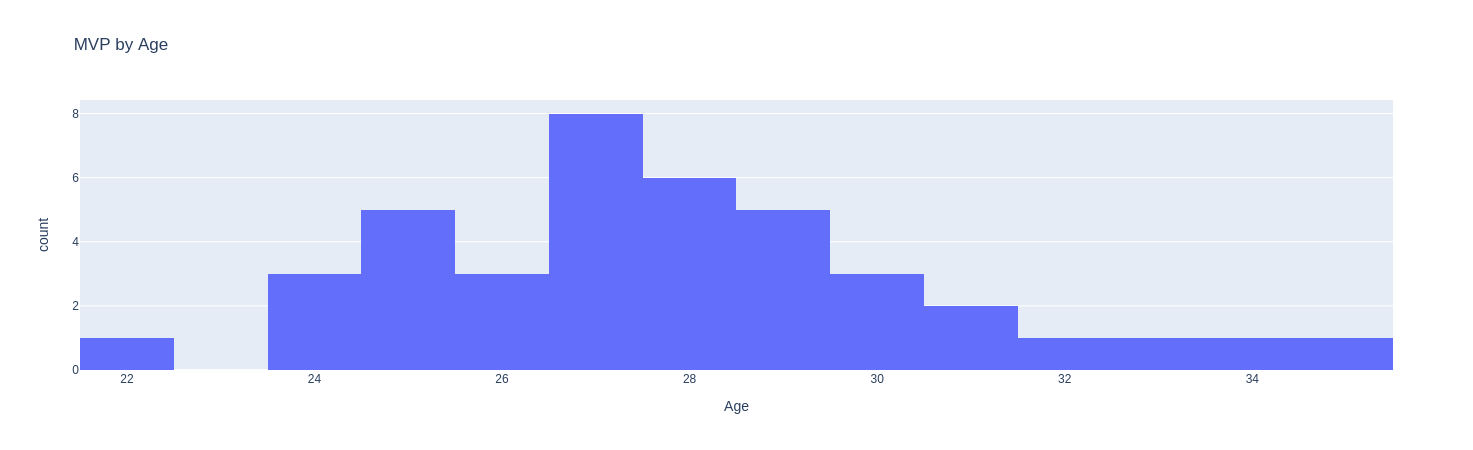

In [23]:
list_b = nba_dataset.loc[(nba_dataset['Status'] == 'MVP'),['Age']]
list_b = list(list_b['Age'].unique())
max_b = max(list_b) + 1
min_b = min(list_b)
bins_to_use = max_b - min_b

fig = px.histogram(nba_dataset.loc[(nba_dataset['Status'] == 'MVP')], x='Age',title='MVP by Age',nbins=int(bins_to_use))
fig.show()

We have **35/40 (87,5%)** between 24 and 31 years and **22/40 ()** between 26 and 29 years.

**Note that these are not the players age when they received the prize. See the glossary.**

In [24]:
dfmvp = nba_dataset.loc[(nba_dataset['Status'] == 'MVP'), :]
dfmvp = dfmvp[['Player','Age']]

display(dfmvp.sort_values(by='Age', ascending=True))

Player  Age
355           Derrick Rose   22
145         Michael Jordan   24
207           LeBron James   24
17   Giannis Antetokounmpo   24
12   Giannis Antetokounmpo   25
133           Kevin Durant   25
221           LeBron James   25
120             Tim Duncan   25
185          Allen Iverson   25
186           Moses Malone   26
111          Stephen Curry   26
108             Tim Duncan   26
104          Stephen Curry   27
232           LeBron James   27
142          Kevin Garnett   27
293       Shaquille O'Neal   27
177           Moses Malone   27
174         Michael Jordan   27
15              Larry Bird   27
132          Magic Johnson   27
193           James Harden   28
457      Russell Westbrook   28
179         Michael Jordan   28
15              Larry Bird   28
301          Dirk Nowitzki   28
211           LeBron James   28
65             Kobe Bryant   29
305         David Robinson   29
23         Charles Barkley   29
16              Larry Bird   29
153          Magic Johnson   29
82           Julius Erving   30
301             Steve Nash   30
160          Magic Johnson   30
294             Steve Nash   31
274        Hakeem Olajuwon   31
189         Michael Jordan   32
227            Karl Malone   33
202         Michael Jordan   34
230            Karl Malone   35

In [25]:
nba_dataset.info()
full_nba_dataset = nba_dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10949 entries, 0 to 528
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  10949 non-null  object 
 1   Pos     10949 non-null  object 
 2   Age     10949 non-null  int64  
 3   3P%     10949 non-null  float64
 4   2P%     10949 non-null  float64
 5   eFG%    10949 non-null  float64
 6   FT%     10949 non-null  float64
 7   ORB     10949 non-null  int64  
 8   DRB     10949 non-null  int64  
 9   AST     10949 non-null  int64  
 10  STL     10949 non-null  int64  
 11  BLK     10949 non-null  int64  
 12  TOV     10949 non-null  int64  
 13  PF      10949 non-null  int64  
 14  PTS     10949 non-null  int64  
 15  PER     10949 non-null  float64
 16  TS%     10949 non-null  float64
 17  TRB%    10949 non-null  float64
 18  AST%    10949 non-null  float64
 19  STL%    10949 non-null  float64
 20  BLK%    10949 non-null  float64
 21  TOV%    10949 non-null  float64
 22  

## Models

In [26]:
def model_measure(y_test, pred):
    r2 = r2_score(y_test, pred)
    RSME = np.sqrt(mean_squared_error(y_test, pred))
    return f'R²:{r2:.2%}\nRSME:{RSME:.2f}'

model = ExtraTreesRegressor()

In [27]:
# Literal Data
cols = ['Player', 'Pos', 'Age','Status'] 
nba_dataset = nba_dataset.drop(cols,axis=1)

0
VORP    0.196539
WS      0.167074
BPM     0.126436
PER     0.113711
PTS     0.063932
USG%    0.043719
TOV     0.023601
3P%     0.019678
FT%     0.019232
Season  0.019049
DRB     0.018031
AST     0.017799
PF      0.017008
2P%     0.016450
STL     0.016383
eFG%    0.015240
AST%    0.014432
TS%     0.013821
TRB%    0.013657
BLK     0.013543
STL%    0.013541
TOV%    0.012917
BLK%    0.012174
ORB     0.012033

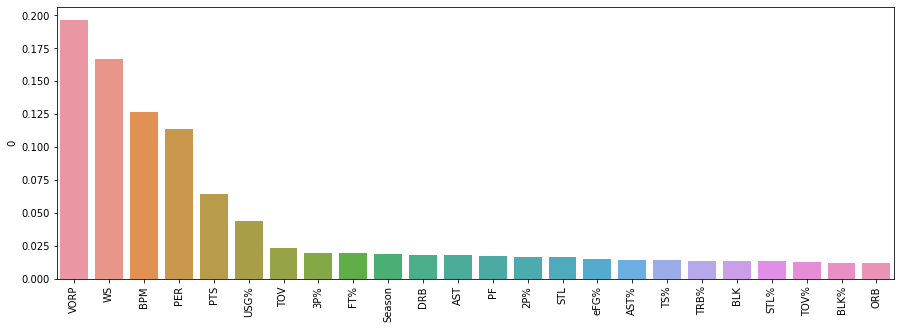

In [28]:
# df = full_nba_dataset.loc[(nba_dataset['Season'] == 2020),['Player','Share','Season']]
# df['Pred'] = pred.tolist()
# df = df.sort_values(by='Share', ascending=False)
# df.to_csv("2020_pred.csv")

X = nba_dataset.drop(['Share'], axis=1)
y = nba_dataset['Share']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

model.fit(X_train, y_train)
features_imporance = pd.DataFrame(model.feature_importances_, X_train.columns)
features_imporance = features_imporance.sort_values(by=0, ascending=False)
display(features_imporance)
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=features_imporance.index, y=features_imporance[0])
ax.tick_params(axis='x', rotation=90)

Gonna use only the first 5 features. Importance >= 0,05.

<Figure size 2160x1800 with 0 Axes>

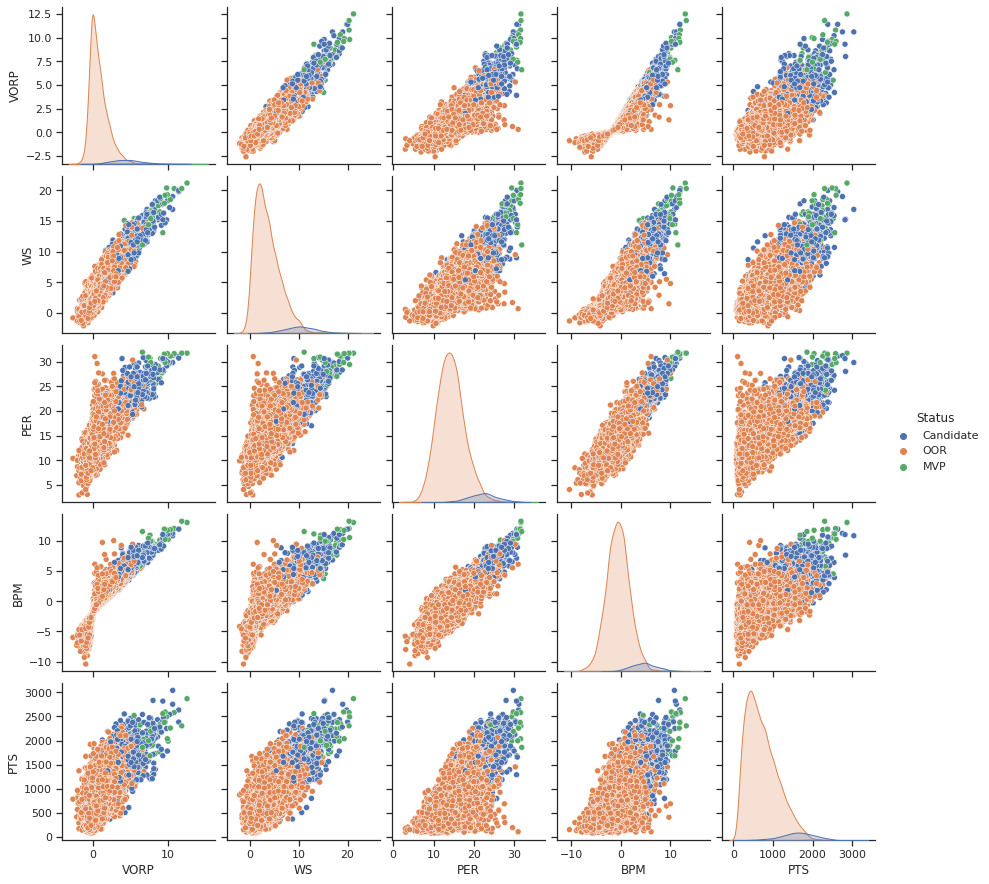

In [29]:
plt.figure(figsize=(30, 25))
sns.set_theme(style="ticks")
df = full_nba_dataset[['VORP','WS','PER','BPM','PTS','Status']]
sns.pairplot(df, hue="Status")

3P%	0.018766
DRB	0.018592
TS%	0.017796
AST	0.016651
TOV%	0.016171
AST%	0.015202
STL	0.014527
eFG%	0.014288
TRB%	0.014069
ORB	0.013704
STL%	0.013133
2P%	0.012645
BLK	0.012509
BLK%	0.010437

In [34]:
nba_dataset = full_nba_dataset[['VORP','WS','PER','BPM','PTS','Season','Share']]

In [37]:
nro_of_corrects = 0
nro_of_top3_corrects = 0
iterations = 20

file = open("output.txt","w")

for season in np.arange(1981,2021,1):
    
    text = f'{season} >> '

    y_train = nba_dataset.loc[(nba_dataset['Season'] != season),['Share']]
    y_train = np.ravel(y_train)
    y_test = nba_dataset.loc[(nba_dataset['Season'] == season),['Share']]
    y_test = np.ravel(y_test)

    X_train = nba_dataset.loc[(nba_dataset['Season'] != season),:].drop(['Share','Season'], axis=1)
    X_test = nba_dataset.loc[(nba_dataset['Season'] == season),:].drop(['Share','Season'], axis=1)

    players_rank = dict()
    df = full_nba_dataset.loc[(nba_dataset['Season'] == season),['Player','Share','Season']]
    df_truth = df.sort_values(by='Share', ascending=False)

    for i in range(iterations):

        model.fit(X_train, y_train)
        pred = model.predict(X_test)
    #     print(model_measure(y_test, pred))

        df['Pred'] = pred.tolist()
        df_pred = df.drop(['Share'],axis=1).sort_values(by='Pred', ascending=False)

        for j in range(5):
            if df_pred.iat[j,0] in players_rank.keys():
                players_rank[df_pred.iat[j,0]] += (10-(j*2))
            else:
                players_rank[df_pred.iat[j,0]] = (10-(j*2))

    players_columns = list(players_rank.keys())
    votes_columns = []

    for k in players_columns:
        votes_columns.append(players_rank[k])

    data = dict()
    data['Player'] = players_columns
    data['Season'] = season
    data['Pred'] = votes_columns

    df_pred_final = pd.DataFrame(data)
    df_pred_final = df_pred_final.sort_values(by='Pred', ascending=False)
    df_pred_final.to_csv(f"./predictions/{season}_pred.csv")

    pred_top3 = list(df_pred_final['Player'].iloc[:3])
    top3 = list(df_truth['Player'].iloc[:3]) 
    top3_success = list()
    
    for z in pred_top3:
        if z in top3:
            top3_success.append(z)

    if pred_top3[0] == top3[0]:
        text += 'Success | '
        nro_of_corrects += 1
    else:
        text += 'Fail | '

    text += f'{len(top3_success)} from de top3 correct | {top3_success} |'
    nro_of_top3_corrects += len(top3_success)

    print(text)
    file.write(str(text))

text = f"GLOBAL_SUCCESS_RATE : {100*(nro_of_corrects/40)}%\nGLOBAL_SUCCESS_RATE_TOP3 : {100*(nro_of_top3_corrects/120)}%"
print(text)
file.write(str(text))
file.close()

1981 >> Fail | 2 from de top3 correct | ['Kareem Abdul-Jabbar', 'Julius Erving'] |
1982 >> Fail | 2 from de top3 correct | ['Julius Erving', 'Moses Malone'] |
1983 >> Fail | 2 from de top3 correct | ['Larry Bird', 'Moses Malone'] |
1984 >> Success | 1 from de top3 correct | ['Larry Bird'] |
1985 >> Success | 2 from de top3 correct | ['Larry Bird', 'Magic Johnson'] |
1986 >> Success | 2 from de top3 correct | ['Larry Bird', 'Magic Johnson'] |
1987 >> Success | 3 from de top3 correct | ['Magic Johnson', 'Larry Bird', 'Michael Jordan'] |
1988 >> Success | 2 from de top3 correct | ['Michael Jordan', 'Larry Bird'] |
1989 >> Fail | 2 from de top3 correct | ['Michael Jordan', 'Magic Johnson'] |
1990 >> Fail | 3 from de top3 correct | ['Michael Jordan', 'Charles Barkley', 'Magic Johnson'] |
1991 >> Success | 2 from de top3 correct | ['Michael Jordan', 'David Robinson'] |
1992 >> Success | 2 from de top3 correct | ['Michael Jordan', 'David Robinson'] |
1993 >> Fail | 2 from de top3 correct | ['